<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/nlp-with-transformers/blob/main/06_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

In [31]:
# 이 노트북에 필요한 라이브러리를 설치합니다.
!pip install transformers datasets accelerate sentencepiece
!pip install sacrebleu rouge_score nltk
# for samsum dataset
!pip install py7zr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.2 MB/s 
     |████████████████████████████████| 2.3 MB 10.7 MB/s 
     |████████████████████████████████| 357 kB 55.2 MB/s 
     |████████████████████████████████| 92 kB 11.0 MB/s 
     |████████████████████████████████| 379 kB 55.0 MB/s 
     |████████████████████████████████| 50 kB 6.2 MB/s 
     |████████████████████████████████| 138 kB 53.9 MB/s 


In [2]:
from transformers import pipeline, set_seed

# 요약

## CNN/DailyMail 데이터셋

In [3]:
from datasets import load_dataset

# "cnn_dailymail" 데이터셋 다운로드 에러가 발생할 경우 대신 "ccdv/cnn_dailymail"을 사용하세요.
dataset = load_dataset("cnn_dailymail", version="3.0.0") 
print(f"특성: {dataset['train'].column_names}")

  0%|          | 0/3 [00:00<?, ?it/s]

특성: ['article', 'highlights', 'id']


In [4]:
sample = dataset["train"][1]
print(f"""기사 (500개 문자 발췌, 총 길이: {len(sample["article"])}):""")
print(sample["article"][:500])
print(f'\n요약 (길이: {len(sample["highlights"])}):')
print(sample["highlights"])

기사 (500개 문자 발췌, 총 길이: 4051):
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most s

요약 (길이: 281):
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .


## 텍스트 요약 파이프라인

In [5]:
sample_text = dataset["train"][1]["article"][:2000]
# 딕셔너리에 각 모델이 생성한 요약을 저장합니다.
summaries = {}

In [6]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
string = "The U.S. are a country. The U.N. is an organization."
sent_tokenize(string)

['The U.S. are a country.', 'The U.N. is an organization.']

### 요약 기준 모델

In [8]:
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

In [9]:
summaries["baseline"] = three_sentence_summary(sample_text)

### GPT-2

In [10]:
from transformers import pipeline, set_seed

set_seed(42)

# 코랩의 경우 gpt2-xl을 사용하면 메모리 부족 에러가 발생합니다.
# 대신 "gpt" 또는 "gpt2-large"로 지정하거나 코랩 프로를 사용하세요.
pipe = pipeline("text-generation", model="gpt2-xl")

gpt2_query = sample_text + "\nTL;DR:\n"
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries["gpt2"] = "\n".join(
    sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) :]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


### T5

<img alt="T5" width="700" caption="Diagram of T5's text-to-text framework (courtesy of Colin Raffel); besides translation and summarization, the CoLA (linguistic acceptability) and STSB (semantic similarity) tasks are shown" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_t5.png?raw=1" id="T5"/>

In [11]:
pipe = pipeline("summarization", model="t5-large")
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5_fast.py:166: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


### BART

In [12]:
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

### PEGASUS

<img alt="pegasus" width="700" caption="Diagram of PEGASUS architecture (courtesy of Jingqing Zhang et al.)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_pegasus.png?raw=1" id="pegasus"/>

In [13]:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")

## 요약 결과 비교하기

In [14]:
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"])
print("")

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

GROUND TRUTH
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .

BASELINE
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.
Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."

GPT2
- Miami-Dade jails have more mentally ill inmates than other counties - About one-third of the mentally ill in Miami-Dade county are housed here - All the mentally ill prisoners have no shoes, no beds, and no mattresse

## 생성된 텍스트 품질 평가하기

### BLEU

In [17]:
from datasets import load_metric

bleu_metric = load_metric("sacrebleu")

In [18]:
import pandas as pd
import numpy as np

bleu_metric.add(
    prediction="the the the the the the", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


In [19]:
bleu_metric.add(
    prediction="the cat is on mat", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


### ROUGE

In [22]:
rouge_metric = load_metric("rouge")

In [23]:
reference = dataset["train"][1]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name], reference=reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
    records.append(rouge_dict)
pd.DataFrame.from_records(records, index=summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.365079,0.145161,0.206349,0.285714
gpt2,0.275229,0.093458,0.201835,0.275229
t5,0.382979,0.130435,0.255319,0.382979
bart,0.475248,0.222222,0.316832,0.415842
pegasus,0.323232,0.206186,0.282828,0.323232


## CNN/DailyMail 데이터셋에서 PEGASUS 평가하기

In [24]:
# 이 셀은 노트북 중간부터 실행하기 위한 것입니다.
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset, load_metric
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# "cnn_dailymail" 데이터셋 다운로드 에러가 발생할 경우 대신 "ccdv/cnn_dailymail"을 사용하세요.
dataset = load_dataset("cnn_dailymail", version="3.0.0") 
rouge_metric = load_metric("rouge", cache_dir=None)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

  0%|          | 0/3 [00:00<?, ?it/s]

In [25]:
def evaluate_summaries_baseline(dataset, metric,
                                column_text="article", 
                                column_summary="highlights"):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries,
                     references=dataset[column_summary])    
    score = metric.compute()
    return score

In [26]:
test_sampled = dataset["test"].shuffle(seed=42).select(range(1000))

score = evaluate_summaries_baseline(test_sampled, rouge_metric)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.389276,0.171296,0.245061,0.354239


In [27]:
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def chunks(list_of_elements, batch_size):
    """list_of_elements로부터 batch_size 크기의 청크를 연속적으로 생성합니다"""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def evaluate_summaries_pegasus(dataset, metric, model, tokenizer, 
                               batch_size=16, device=device, 
                               column_text="article", 
                               column_summary="highlights"):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        
        inputs = tokenizer(article_batch, max_length=1024,  truncation=True, 
                        padding="max_length", return_tensors="pt")
        
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device), 
                         length_penalty=0.8, num_beams=8, max_length=128)
        
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                clean_up_tokenization_spaces=True) 
               for s in summaries]
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    score = metric.compute()
    return score

In [28]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
score = evaluate_summaries_pegasus(test_sampled, rouge_metric, 
                                   model, tokenizer, batch_size=8)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

100%|██████████| 125/125 [16:48<00:00,  8.07s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.434759,0.216742,0.312271,0.374631


In [29]:
pd.DataFrame(rouge_dict, index=["pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.434759,0.216742,0.312271,0.374631


## 요약 모델 훈련하기

In [32]:
dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]

print(f"분할 크기: {split_lengths}")
print(f"특성: {dataset_samsum['train'].column_names}")
print("\n대화:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Dataset samsum downloaded and prepared to /root/.cache/huggingface/datasets/samsum/samsum/0.0.0/f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

분할 크기: [14732, 819, 818]
특성: ['id', 'dialogue', 'summary']

대화:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


### SAMSum에서 PEGASUS 평가하기

In [33]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("요약:")
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))

Your max_length is set to 128, but you input_length is only 122. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


요약:
Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


In [34]:
score = evaluate_summaries_pegasus(dataset_samsum["test"], rouge_metric, model,
                                   tokenizer, column_text="dialogue",
                                   column_summary="summary", batch_size=8)

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

100%|██████████| 103/103 [12:19<00:00,  7.18s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.296091,0.087493,0.229237,0.229642


In [35]:
pd.DataFrame(rouge_dict, index=["pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.296091,0.087493,0.229237,0.229642


### PEGASUS 미세 튜닝하기

Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


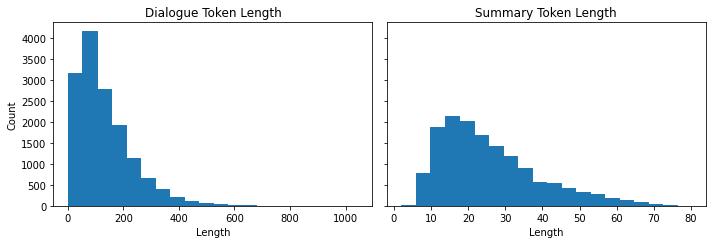

In [36]:
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [37]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024,
                                truncation=True)
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128,
                                     truncation=True)
    
    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, 
                                       batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [38]:
# 티처 포싱(teacher forcing)
# 텍스트 생성을 위한 디코더 입력과 레이블의 정렬
text = ['PAD','Transformers', 'are', 'awesome', 'for', 'text', 'summarization']
rows = []
for i in range(len(text)-1):
    rows.append({'step': i+1, 'decoder_input': text[:i+1], 'label': text[i+1]})
pd.DataFrame(rows).set_index('step')

,decoder_input,label
step,,
1,[PAD],Transformers
2,"[PAD, Transformers]",are
3,"[PAD, Transformers, are]",awesome
4,"[PAD, Transformers, are, awesome]",for
5,"[PAD, Transformers, are, awesome, for]",text
6,"[PAD, Transformers, are, awesome, for, text]",summarization


In [39]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [40]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10, push_to_hub=True,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16)

In [41]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [43]:
trainer = Trainer(model=model, args=training_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"], 
                  eval_dataset=dataset_samsum_pt["validation"])

Cloning https://huggingface.co/haesun/pegasus-samsum into local empty directory.


Download file pytorch_model.bin:   0%|          | 8.37k/2.13G [00:00<?, ?B/s]

Download file runs/Aug01_02-16-35_default/1659321148.5612001/events.out.tfevents.1659321148.default.183.3:  79…

Download file runs/Sep03_07-11-01_26606349e738/events.out.tfevents.1662190833.26606349e738.77.0:  18%|#8      …

Download file runs/Aug01_03-31-25_default/1659324691.6091912/events.out.tfevents.1659324691.default.493.1:  66…

Download file runs/Aug01_02-16-35_default/1659320203.0345788/events.out.tfevents.1659320203.default.183.1:  79…

Download file runs/Sep03_07-11-01_26606349e738/1662190833.3421242/events.out.tfevents.1662190833.26606349e738.…

Download file spiece.model:   0%|          | 3.48k/1.82M [00:00<?, ?B/s]

Download file runs/Aug01_03-31-25_default/events.out.tfevents.1659324691.default.493.0:  44%|####4     | 8.37k…

Clean file runs/Aug01_02-16-35_default/1659321148.5612001/events.out.tfevents.1659321148.default.183.3:  23%|#…

Clean file runs/Aug01_03-31-25_default/1659324691.6091912/events.out.tfevents.1659324691.default.493.1:  19%|#…

Clean file runs/Aug01_02-16-35_default/1659320203.0345788/events.out.tfevents.1659320203.default.183.1:  23%|#…

Clean file runs/Sep03_07-11-01_26606349e738/1662190833.3421242/events.out.tfevents.1662190833.26606349e738.77.…

Clean file runs/Sep03_07-11-01_26606349e738/events.out.tfevents.1662190833.26606349e738.77.0:   5%|5         |…

Clean file runs/Aug01_03-31-25_default/events.out.tfevents.1659324691.default.493.0:   5%|5         | 1.00k/18…

Download file runs/Aug01_02-16-35_default/events.out.tfevents.1659321148.default.183.2: 100%|##########| 40.0/…

Clean file runs/Aug01_02-16-35_default/events.out.tfevents.1659321148.default.183.2: 100%|##########| 40.0/40.…

Download file training_args.bin: 100%|##########| 3.23k/3.23k [00:00<?, ?B/s]

Clean file training_args.bin:  31%|###       | 1.00k/3.23k [00:00<?, ?B/s]

Download file runs/Aug01_02-16-35_default/events.out.tfevents.1659320203.default.183.0:  93%|#########3| 3.48k…

Clean file runs/Aug01_02-16-35_default/events.out.tfevents.1659320203.default.183.0:  27%|##6       | 1.00k/3.…

Clean file spiece.model:   0%|          | 1.00k/1.82M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/2.13G [00:00<?, ?B/s]

In [44]:
trainer.train()
score = evaluate_summaries_pegasus(
    dataset_samsum["test"], rouge_metric, trainer.model, tokenizer,
    batch_size=2, column_text="dialogue", column_summary="summary")

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"pegasus"])

The following columns in the training set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: summary, id, dialogue. If summary, id, dialogue are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 14732
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 16
  Total optimization steps = 920


Step,Training Loss,Validation Loss
500,1.700300,1.485897


The following columns in the evaluation set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: summary, id, dialogue. If summary, id, dialogue are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 818
  Batch size = 1


Training completed. Do not forget to share your model on huggingface.co/models =)


100%|██████████| 410/410 [10:41<00:00,  1.56s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.42586,0.198685,0.340473,0.340559


In [45]:
pd.DataFrame(rouge_dict, index=[f"pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.42586,0.198685,0.340473,0.340559


In [46]:
trainer.push_to_hub("Training complete!")

Saving model checkpoint to pegasus-samsum
Configuration saved in pegasus-samsum/config.json
Model weights saved in pegasus-samsum/pytorch_model.bin
tokenizer config file saved in pegasus-samsum/tokenizer_config.json
Special tokens file saved in pegasus-samsum/special_tokens_map.json


Upload file runs/Sep03_10-06-51_fb108a177a1e/events.out.tfevents.1662200558.fb108a177a1e.365.0:  18%|#7       …

Upload file training_args.bin: 100%|##########| 3.23k/3.23k [00:00<?, ?B/s]

Upload file runs/Sep03_10-06-51_fb108a177a1e/1662200558.9387803/events.out.tfevents.1662200558.fb108a177a1e.36…

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/haesun/pegasus-samsum
   350823d..522ce4b  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/haesun/pegasus-samsum
   350823d..522ce4b  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Sequence-to-sequence Language Modeling', 'type': 'text2text-generation'}, 'dataset': {'name': 'samsum', 'type': 'samsum', 'config': 'samsum', 'split': 'train', 'args': 'samsum'}}


'https://huggingface.co/haesun/pegasus-samsum/commit/522ce4bd90829353bd7db01d9f421a1da8a47214'

### 대화 요약 생성하기

In [47]:
import transformers
transformers.logging.set_verbosity_error()

In [48]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
# `haesun`를 자신의 허브 사용자 이름으로 바꾸세요.
pipe = pipeline("summarization", model="haesun/pegasus-samsum")

print("대화:")
print(sample_text)
print("\n참조 요약:")
print(reference)
print("\n모델 요약:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

대화:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

참조 요약:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

모델 요약:
Amanda can't find Betty's number. Larry called Betty's last time they were at the park together. Hannah wants Amanda to text him.


In [49]:
custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!
"""
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

Thom, Lewis and Leandro are going to write a book about transformers. Thom helped build a library by Hugging Face. They are going to do it together.


## 결론